# Using Sumatra with Pandas in IPython

This notebook demonstrates how to use
[Sumatra](http://neuralensemble.org/sumatra/) to capture simulation
input data and meta data and then
export these records into a Pandas data frame.  Sumatra has a stand
alone web interface built with Django which allows users to view the
data. Data can also be imported into Python, but requires a lot of
code to manipulate and display in useful custom formats. Pandas seems
like the ideal solution for manipulating Sumatra's data. In particular
the ability to easily and quickly combine input data, meta data, and
output data into custom data frames is really powerful for
data analysis, reproduciblity and sharing.

The first step in using Sumatra is to setup a simulation. Here the
simulation just runs a diffusion problem using FiPy and outputs the
time taken for a time step. The goal of the work is to test FiPy's parallel
speed up based on different input parameters.


# Setup the Simulations

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

Sumatra requires a file with the parameters specified.

In [2]:
import json

params = {'N' : 10, 'suite' : 'pysparse', 'iterations' : 100}

with open('params.json', 'w') as fp:
    json.dump(params, fp)

The script file for running the simulation is `fipy_timing.py`. It reads the JSON file, runs the simulation and the stores the run times in `data.txt`.

In [3]:
%%writefile fipy_timing.py

"""
Usage: fipy_timing.py [<jsonfile>]

"""

from docopt import docopt
import json
import timeit
import numpy as np
import fipy as fp
import os

arguments = docopt(__doc__, version='Run FiPy timing')
jsonfile = arguments['<jsonfile>']

if jsonfile:
    with open(jsonfile, 'rb') as ff:
        params = json.load(ff)
else:
    params = dict()
    
N = params.get('N', 10)
iterations = params.get('iterations', 100)
suite = params.get('suite', 'pysparse')
sumatra_label = params.get('sumatra_label', '')

attempts = 3

setup_str = '''
import fipy as fp
import numpy as np
np.random.seed(1)
L = 1.
N = {N:d}
m = fp.GmshGrid3D(nx=N, ny=N, nz=N, dx=L / N, dy=L / N, dz=L / N)
v0 = np.random.random(m.numberOfCells)
v = fp.CellVariable(mesh=m)
v0 = np.resize(v0, len(v)) ## Gmsh doesn't always give us the correct sized grid!
eqn = fp.TransientTerm(1e-3) == fp.DiffusionTerm()
v[:] = v0.copy()

import fipy.solvers.{suite} as solvers
solver = solvers.linearPCGSolver.LinearPCGSolver(precon=None, iterations={iterations}, tolerance=1e-100)

eqn.solve(v, dt=1., solver=solver)
v[:] = v0.copy()
'''

timeit_str = '''
eqn.solve(v, dt=1., solver=solver)
fp.parallelComm.Barrier()
'''

timer = timeit.Timer(timeit_str, setup=setup_str.format(N=N, suite=suite, iterations=iterations))
times = timer.repeat(attempts, 1)

# if fp.parallelComm.procID == 0:
filepath = os.path.join('Data', sumatra_label)
filename = 'data.txt'
np.savetxt(os.path.join(filepath, filename), times)

print times

Overwriting fipy_timing.py


Without using Sumatra and in serial this is run with

In [4]:
#to install gmsh run "conda install --channel guyer numpy==1.9 pysparse pip gmsh"
#to install PyTrilinos run "conda install --channel guyer numpy==1.9 pysparse openmpi trilinos mpi4py"
#trilinos is mainly used for linear solvers, it also includes PDE solvers but they are low level, FiPy is a better PDE solvers

#but actually you should use pysparse instead of trilinos
!python fipy_timing.py params.json

/users/aem1/miniconda2/lib/python2.7/timeit.py:19: MaximumIterationWarning: Iterations: 101. Relative error: 1.81008e-08
  -c/--clock: use time.clock() (default on Windows)
/users/aem1/miniconda2/lib/python2.7/timeit.py:25: MaximumIterationWarning: Iterations: 101. Relative error: 1.81008e-08
  A multi-line statement may be given by specifying each line as a
[0.014670133590698242, 0.03576397895812988, 0.016131877899169922]


and the output data file is 

In [5]:
!more Data/data.txt

1.467013359069824219e-02
3.576397895812988281e-02
1.613187789916992188e-02


# Create a Git Repository

In this demo, I'm assuming that the working directory is a Git repository set up with

    $ git init
$ git add fipy_timing.py
    $ git ci -m "Add timing script."
    
Sumatra requires that the script is sitting in the a working copy of a repository.

In [6]:
!git log -1

commit 3471a177167a8ca73e608f82a50f6a265c10db1a
Author: Daniel Wheeler <daniel.wheeler2@gmail.com>
Date:   Fri Mar 7 15:01:27 2014 -0500

    Changes prompted by Jon's use of the repository.
    
     * Add `mkdir Data`, which Sumatra requires.
    
     * Add Sumatra as a requirement and changes I made to Sumatra.
    
     * Add imports at beginning of Demo.
    
     * Fix the demo so it can be executed without failure
    
     * Include chnages made to Sumatra.
    
     * Added changes made to


# Configure Sumatra

Once the repository is setup, the Sumatra repository can be configured. Here we are using the `distributed` launch mode as we want Sumatra to launch and
record parallel jobs.

In [7]:
%%bash

\rm -rf .smt
smt init smt-demo
smt configure --executable=python --main=fipy_timing.py
smt configure --launch_mode=serial
smt configure -g uuid
smt configure -c store-diff
smt configure --addlabel=parameters

Sumatra project successfully set up
Multiple versions found, using /users/aem1/miniconda2/bin/python. If you wish to use a different version, please specify it explicitly
Multiple versions found, using /users/aem1/miniconda2/bin/python. If you wish to use a different version, please specify it explicitly


Sumatra requires that  a `Data/` directory exists in the working copy.

In [54]:
!mkdir Data

mkdir: cannot create directory ‘Data’: File exists


If we were not using Sumatra, we would launch the job with 

    $ mpirun -n 2 python fipy_timing.py params.json
    
The equivalent command using Sumatra is

    $ smt run -n 2 params.json
 

# Run Simulations

In the following cell we just run a batch of simulations with varying parameters.

In [8]:
import itertools

nprocs = (1,)#
iterations_ = (100,)
Ns = (10, 11) #changed (10,40) to (10,11) for less runs
suites = ('pysparse',)
tag='demo4'

for nproc, iterations, N, suite in itertools.product(nprocs, iterations_, Ns, suites):
    !smt run --tag=$tag params.json N=$N iterations=$iterations suite=$suite

/users/aem1/miniconda2/lib/python2.7/timeit.py:19: MaximumIterationWarning: Iterations: 101. Relative error: 1.81008e-08
  -c/--clock: use time.clock() (default on Windows)
/users/aem1/miniconda2/lib/python2.7/timeit.py:25: MaximumIterationWarning: Iterations: 101. Relative error: 1.81008e-08
  A multi-line statement may be given by specifying each line as a
[0.014488935470581055, 0.014088869094848633, 0.014143943786621094]
Record label for this run: '1ad2421806fb'
Data keys are [data.txt(0d3d7da194ee3ec0109eec2c72adeb0912c52acb [2016-06-06 09:16:50])]
/users/aem1/miniconda2/lib/python2.7/timeit.py:19: MaximumIterationWarning: Iterations: 101. Relative error: 7.22033e-07
  -c/--clock: use time.clock() (default on Windows)
/users/aem1/miniconda2/lib/python2.7/timeit.py:25: MaximumIterationWarning: Iterations: 101. Relative error: 7.22033e-07
  A multi-line statement may be given by specifying each line as a
[0.0161130428314209, 0.015719175338745117, 0.015771865844726562]
Record label fo

# Import into Pandas Dataframe

The important part of this story is how to import the data into the Pandas data frame. This is actually trivial as Sumatra's default export format is a JSON file with all the records.

In [9]:
import json
import pandas

!smt export
with open('.smt/records_export.json') as ff:
    data = json.load(ff)

with open('record1.json', 'w') as record1:
    record1.write(json.dumps(data[0], sort_keys=True, indent=4, separators=(',', ': ')))

df = pandas.DataFrame(data)

The Sumatra data is now in a Pandas data frame, albeit a touch raw.

In [94]:
print df['parameters']

0    {u'content': u'{
    "N": 11, 
    "iterations...
1    {u'content': u'{
    "N": 10, 
    "iterations...
Name: parameters, dtype: object


In [95]:
print df[['label', 'duration']]

          label  duration
0  6cee1bdcbf7e  2.394176
1  55513714ade7  1.960150


# Reformat the Raw Imported Dataframe

While all the meta data is important, often we want the input and
output data combined into a data frame in a digestible
form. Typically, we want a graph of reduced input versus reduced
output.

The first step is to introduce columns in the data frame for each of the input parameters (input data). The input data is buried in the `launch_mode` and `parameters` columns of the raw data frame.

In [96]:
for index in range(len(df['launch_mode'])):
   print df['launch_mode'][index]['type']
#    print df['launch_mode'][index]['parameters']

SerialLaunchMode
SerialLaunchMode


In [12]:
#not running this cell anymore, it is the original
import json
df = df.copy()
print df.parameters
df['nproc'] = 1 # We are running in serial
for p in 'N', 'iterations', 'suite':
    df[p] = df.parameters.map(lambda x: json.loads(x['content'])[p])

# print df.parameters[0]

0    {u'content': u'{
    "N": 11, 
    "iterations...
1    {u'content': u'{
    "N": 10, 
    "iterations...
Name: parameters, dtype: object


We now have the input data exposed as columns in the data frame.

In [13]:
columns = ['label', 'nproc', 'N', 'iterations', 'suite', 'tags']
print df[columns]

          label  nproc   N  iterations     suite     tags
0  dfd4cf51887c      1  11         100  pysparse  [demo4]
1  1ad2421806fb      1  10         100  pysparse  [demo4]


The following pulls out the run times stored in the output files from each simulation into a `run_time` column.

In [15]:
import os

datafiles = df['output_data'].map(lambda x: x[0]['path']) 
datapaths = df['datastore'].map(lambda x: x['parameters']['root'])
data = [np.loadtxt(os.path.join(x, y)) for x, y in zip(datapaths, datafiles)]
print data
df['run_time'] = [min(d) for d in data]
# print df['output_data'][0]

[array([ 0.01611304,  0.01571918,  0.01577187]), array([ 0.01448894,  0.01408887,  0.01414394])]


In [109]:
columns.append('run_time')
print df[columns]

          label  nproc   N  iterations     suite     tags  run_time  run_time
0  6cee1bdcbf7e      1  11         100  pysparse  [demo4]  0.017032  0.017032
1  55513714ade7      1  10         100  pysparse  [demo4]  0.014171  0.014171


Create masks based on simulations records that have been tagged with either `demo2` or `demo3`. We want to plot these results as different curves on the same graph.

In [25]:
# del(df_tmp)
print df_tmp
tag_mask = df.tags.map(lambda x: 'demo4' in x)
df_tmp = df[tag_mask]
m10 = df_tmp.N.map(lambda x: x == 10)
m40 = df_tmp.N.map(lambda x: x == 11)
df_N10 = df_tmp[m10]
df_N40 = df_tmp[m40]
print df_N10[columns]
print df_N40[columns]

# print df_tmp

                                           datastore  \
0  {u'type': u'FileSystemDataStore', u'parameters...   
1  {u'type': u'FileSystemDataStore', u'parameters...   

                                        dependencies  \
0  [{u'name': u'IPython', u'module': u'python', u...   
1  [{u'name': u'IPython', u'module': u'python', u...   

                                                diff  duration  \
0  diff --git a/demo.ipynb b/demo.ipynb\nindex 5d...  4.966687   
1  diff --git a/demo.ipynb b/demo.ipynb\nindex 5d...  1.794884   

                                          executable input_data  \
0  {u'path': u'/users/aem1/miniconda2/bin/python'...         []   
1  {u'path': u'/users/aem1/miniconda2/bin/python'...         []   

                                     input_datastore         label  \
0  {u'type': u'FileSystemDataStore', u'parameters...  dfd4cf51887c   
1  {u'type': u'FileSystemDataStore', u'parameters...  1ad2421806fb   

                                         launch_mo

In [27]:
print df_N10

                                           datastore  \
1  {u'type': u'FileSystemDataStore', u'parameters...   

                                        dependencies  \
1  [{u'name': u'IPython', u'module': u'python', u...   

                                                diff  duration  \
1  diff --git a/demo.ipynb b/demo.ipynb\nindex 5d...  1.794884   

                                          executable input_data  \
1  {u'path': u'/users/aem1/miniconda2/bin/python'...         []   

                                     input_datastore         label  \
1  {u'type': u'FileSystemDataStore', u'parameters...  1ad2421806fb   

                                         launch_mode       main_file  \
1  {u'type': u'SerialLaunchMode', u'parameters': ...  fipy_timing.py   

     ...                                         stdout_stderr     tags  \
1    ...     /users/aem1/miniconda2/lib/python2.7/timeit.py...  [demo4]   

             timestamp                                            use

We can plot the results we're interested in. Larger system size gives better parallel speed up.

/users/aem1/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10.0, right=10.0
  'left=%s, right=%s') % (left, right))


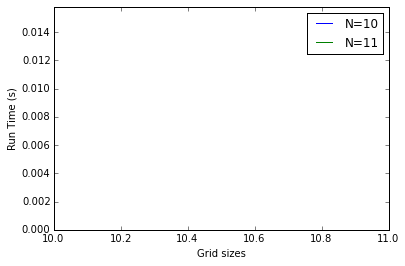

In [26]:
ax = df_N10.plot('N', 'run_time', label='N={0}'.format(df_N10.N.iat[0]))
df_N40.plot('N', 'run_time', ylim=0, ax=ax, label='N={0}'.format(df_N40.N.iat[0]))
plt.ylabel('Run Time (s)')
plt.xlabel('Grid sizes')
plt.legend()

Using Pandas it is easy to store a custom data frame.

In [115]:
df.to_hdf('store.h5', 'df')

ImportError: HDFStore requires PyTables, "No module named tables" problem importing

In [116]:
b
print store.df.dependencies

NameError: name 'b' is not defined

In [117]:
import pandas as pd

df = pd.DataFrame({'a' : [1, 2, 3], 'b' : ['a', 'b', 'c']})
df['c'] = [5, 6, 7]
print df


   a  b  c
0  1  a  5
1  2  b  6
2  3  c  7


# Conclusion

Sumatra stores data in an SQL style database and this isn't ideal for pulling data into Python for data manipulation. Pandas is good for data manipulation and pulling the records out of Sumatra and into Pandas is very easy.